In [1]:
import torch 
from matplotlib import pyplot as plt 
from tkgdti.train.utils import device_and_data_loading
import argparse 
from tkgdti.data.TriplesDatasetGNN import TriplesDatasetGNN
from tkgdti.data.process_graph import process_graph
import torch_geometric as pyg
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx

In [2]:
res = torch.load('../output/gnn/results_99.pt')
model = res['model']

In [3]:
args = argparse.Namespace() 
args.data = '/home/teddy/local/KGDTI/data/HeteroA/processed/FOLD_0'
args.verbose = True

device, data, train_triples, valid_triples, \
        valid_neg_triples, test_triples, test_neg_triples  = device_and_data_loading(args, return_test=True)

tdata = process_graph(data)

edge_index_dict = {key: tdata[key]['edge_index'] for key in tdata.metadata()[1]}
num_node_dict = {key: tdata[key].num_nodes for key in tdata.metadata()[0]}


device: cuda


In [4]:
datas = []
for i in range(data['num_nodes_dict']['drug']):
    head = i 
    x_dict = {node:torch.zeros((num_nodes, 1), dtype=torch.float32) for node, num_nodes in num_node_dict.items()}

    x_dict['drug'][head] = torch.ones((1,), dtype=torch.float32)

    edge_index_dict = edge_index_dict

    # Create a HeteroData object for this instance
    dat = pyg.data.HeteroData()

    # Add node features
    for node_type in x_dict:
        dat[node_type].x = x_dict[node_type]

    # Add edge indices
    for edge_type in edge_index_dict:
        src_type, relation, dst_type = edge_type
        dat[(src_type, relation, dst_type)].edge_index = edge_index_dict[edge_type]

    datas.append(dat)

In [44]:
# didx=4,9,12 
drug_idx = 24
prot_idx = tdata.metadata()[0].index('protein')
dat = datas[drug_idx].to_homogeneous()
out = model(dat.x.to(device), dat.edge_index.to(device), dat.edge_type.to(device))
prot_mask = dat.node_type == prot_idx
prot_probs = out[prot_mask] 
prot_idx = prot_probs.argmax()

# convert prot_idx to global idx
rng = torch.arange(out.size(0))
targ_idx = rng[prot_mask][prot_idx]

# convert drug_idx to global idx 
src_idx = dat.x[:, 0].nonzero().squeeze()

print('drug_idx:', drug_idx)
print('prot_idx:', prot_idx)
print('prot_idx prob (target):', prot_probs[prot_idx])  # larger probs will probably work better 
print('targ_idx:', targ_idx)
print('src_idx:', src_idx)

assert out[targ_idx] == prot_probs[prot_idx], 'something went wrong'

drug_idx: 24
prot_idx: tensor(26, device='cuda:0')
prot_idx prob (target): tensor([0.9156], device='cuda:0', grad_fn=<SelectBackward0>)
targ_idx: tensor(6337)
src_idx: tensor(24)


In [45]:
model.eval() 

explainer = Explainer(
    model=model,
    #algorithm=pyg.explain.GNNExplainer(edge_size=0.001, epochs=100, lr=1e-2),
    algorithm=pyg.explain.AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),
)

explanation = explainer(x=dat.x.to(device), edge_index=dat.edge_index.to(device), edge_type=dat.edge_type.to(device), index=targ_idx)
print(f'Generated explanations in {explanation.available_explanations}')

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

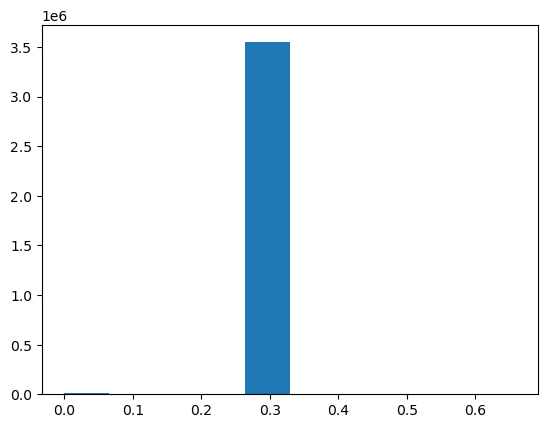

In [42]:
plt.figure()
plt.hist(explanation.edge_mask.cpu().numpy(), bins=10)
plt.show()

NetworkXError: Node 'DB00202' has no position.

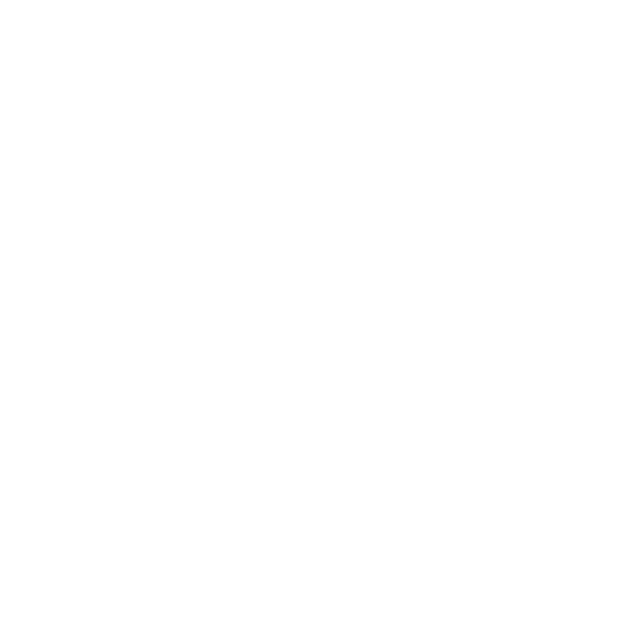

In [ ]:
subgraph = explanation.get_explanation_subgraph()
sub_edge_index = subgraph.edge_index[:, subgraph.edge_mask > 0.5]

node_names = [] 
for ntype in tdata.metadata()[0]: 
    node_names += tdata[ntype].names
node_names = np.array(node_names)

G = nx.DiGraph() 
for src,dst in sub_edge_index.T: 
    G.add_edge(node_names[src.item()], node_names[dst.item()])

sz = 1000

# color drug (src_idx) red and prot (targ_idx) blue, all other nodes should be gray 
# fix the drug at the top of the graph and the prot at the bottom
# change shape of nodes to be rectangles
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42, 
                       fixed=[node_names[src_idx.item()], node_names[targ_idx.item()]], 
                       pos={node_names[src_idx.item()]: (0, 1), node_names[targ_idx.item()]: (0, 0)})
nx.draw(G, pos, with_labels=True, node_size=sz, node_color='gray', node_shape='s')
nx.draw_networkx_nodes(G, pos, nodelist=[node_names[src_idx.item()]], node_color='red', node_size=sz)
nx.draw_networkx_nodes(G, pos, nodelist=[node_names[targ_idx.item()]], node_color='blue', node_size=sz)
plt.show()

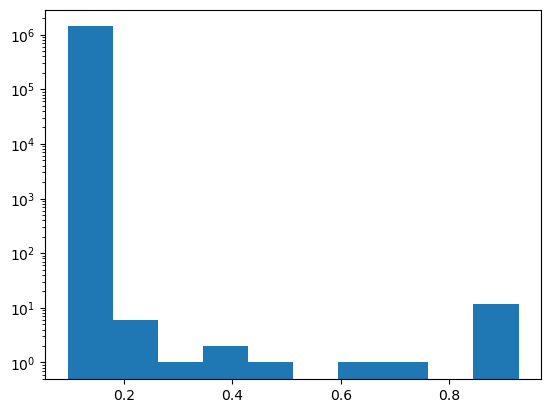

In [ ]:
plt.figure()
plt.hist( subgraph.edge_mask.detach().cpu().numpy() ) 
plt.yscale('log')
plt.show()

In [9]:
explanation.validate()

True

In [ ]:
subgraph = explanation.get_explanation_subgraph()